
# Module 2 - In this jupyter notebook, the seasonal T, ET, RET, NPP are calculated 

* Step 2a - Set up: Import modules/libraries, inport data, create output folder
* Step 2b - Defining function 
* Step 2c - Calculate seasonal T, ET, RET, ETp, NPP

**============================================================================================================**

![title](https://github.com/wateraccounting/WAPORWP/blob/master/Notebooks/img/Fig2_1.png?raw=true)

**===========================================================================================================**

## Step 2a - Set up

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## i) Import modules/libraries

In [2]:
import os                                 # a module for interacting with the operating system
import sys
import glob                               # used to retrieve files/pathnames matching a specified pattern
import re                                 # re sub() module can be used to replace substring

import pandas as pd                       # to store and manipulate tabular data in rows of observations and columns of variables
import numpy as np                        # stands for 'Numerical Python, is a python library used for scientific computing with arrays
import calendar
import datetime
from scipy.interpolate import interp1d
from matplotlib import pyplot as plt      # is a plotting library used for 2D graphics in python 


# change the directory to where the modules are saved/ change working directory to 'Modules' folder
sys.path.insert(0,'/content/drive/My Drive/WAPORWP/Modules')
from GIS_functions import GIS_function as gis

## ii) Import the input data:
* WaPOR data (T, AETI, REF, NPP), 
* Dates corresponding to the raster layer and 
* Start and end of cropseason and crop coefficient (Kc) of crop

## * Import raster (WaPOR) data

In [3]:
dir_proj = '/content/drive/My Drive/WAPORWP'
dir_data = "Data"

# transpiration, evapotranspiration & interceptio and reference evapotranspiration
input_folderT = os.path.join(dir_proj, dir_data, "1_L2_T_filtered") 
input_fhsT = sorted(glob.glob(input_folderT + '/*.tif'))                 # glob.glob returns the list of files with their full path

input_folderET = os.path.join(dir_proj, dir_data, "1_L2_AETI_filtered") 
input_fhsET = sorted(glob.glob(input_folderET + '/*.tif'))

input_folderRET = os.path.join(dir_proj, dir_data, "1_L1_RET_filtered") 
input_fhsRET = sorted(glob.glob(input_folderRET + '/*.tif'))

input_folderNPP = os.path.join(dir_proj, dir_data, "1_L2_NPP_filtered") 
input_fhsNPP = sorted(glob.glob(input_folderNPP + '/*.tif'))

input_folderPCP = os.path.join(dir_proj, dir_data, "1_L1_PCP_D_resampled") 
input_fhsPCP = sorted(glob.glob(input_folderPCP + '/*.tif'))

## ** Import the dates corresponding to the raster layers of WaPOR (cube code)

![title](https://github.com/wateraccounting/WAPORWP/blob/master/Notebooks/img/Fig2_2.jpg?raw=true), ![title](https://github.com/wateraccounting/WAPORWP/blob/master/Notebooks/img/Fig2_3.png?raw=true)

* Running the following cell activate the 'WaPOR' module that requires internet connection and takes longtime to download the the catalog 
* <span style='background :lightgreen' > **Run the cell only one time, if the latest date in the 'time_range' is updated.**
* <span style='background :pink' > While running this section for the first time, the the catalog info is saved in the working directory in excel file (e.g. df_availET.xlsx).
* <span style='background :pink' > Running the notebook for the second time should skip this cell, but run the next one (# read the df_avial from already saved excel under the Data) 

In [4]:
sys.path.insert(0,'/content/drive/My Drive/WAPORWP/Modules')
# sys.path.append(folder) #add folder with local modules to system paths  #change working directory to 'Modules' folder
import WaPOR                                # an API to interact with WaPOR portal

# read the cube info (dataframe) from the cataloge 
cube_codeT   = 'L2_T_D' 
cube_codeET  = 'L2_AETI_D' 
cube_codeRET = 'L1_RET_D' 
cube_codeNPP = 'L2_NPP_D' 
cube_codePCP = 'L1_PCP_D' 


time_range   = '2009-01-01,2020-12-31'

df_availT    = WaPOR.API.getAvailData(cube_codeT,   time_range)
df_availET   = WaPOR.API.getAvailData(cube_codeET,  time_range)
df_availRET  = WaPOR.API.getAvailData(cube_codeRET, time_range)
df_availNPP  = WaPOR.API.getAvailData(cube_codeNPP, time_range)
df_availPCP  = WaPOR.API.getAvailData(cube_codePCP, time_range)

# save the dataframe to excel to access it offline
output_folder = os.path.join(dir_proj, dir_data)

df_availT.to_excel(os.path.join(output_folder,   'df_availT.xlsx'))
df_availET.to_excel(os.path.join(output_folder,  'df_availET.xlsx'))
df_availRET.to_excel(os.path.join(output_folder, 'df_availRET.xlsx'))
df_availNPP.to_excel(os.path.join(output_folder, 'df_availNPP.xlsx'))
df_availPCP.to_excel(os.path.join(output_folder, 'df_availPCP.xlsx')) 

# Get personaL WAPOR API Token by registering in the top right cornor of the page: wapor.apps.fao.org/home/1

Obtained saved API Token
Your WaPOR API Token is saved into: /content/drive/My Drive/WAPORWP/Modules/WaPOR/wapor_api_token.pickle. 
 If you wish to change your API Token, please delete this file
Loading WaPOR catalog from cached file: /content/drive/My Drive/WAPORWP/Modules/WaPOR/catalog_2.pickle
Cached WaPOR catalog has been loaded.
If you wish to update catalog from WaPOR server, run this line:
WaPOR.API.getCatalog(cached=False)


## *** Define and import the Start Of crop Season (SOS) and End Of crop Season (EOS)
* Edit the start and end of crop seasons **in the df_SOsEos.xlsx file in the data folder**
* You can add or delete rows depending on the number of seasons 

In [5]:
df_dates = pd.read_excel(os.path.join(dir_proj, dir_data,'df_SosEos.xlsx'))
df_dates

,Seasons,SOS,EOS
0,1.0,2016-10-01,2017-09-30


## **** Define and import the Kc per month
* The Edit the **months** the corresponding **Kc** value in the order of start of crop season (inital stage) to end of crop season (late-season stage) **in the df_Kc.xlsx file in the data folder**
* The rows should be for months within the duration of the crop season 
* The figure below shows the Kc curve of a sugarcane, given as example
![title](https://github.com/wateraccounting/WAPORWP/blob/master/Notebooks/img/Fig3_2.PNG?raw=true)

In [6]:
df_kc = pd.read_excel(os.path.join(dir_proj, dir_data,'df_Kc.xlsx'))
df_kc 

,Stages,Days,kc,Unnamed: 3,Crop stages,Duration_days,Kc
0,Initial_s,0.0,0.40,NaN,Initial,30.0,0.40
1,Initial_e,30.0,0.40,NaN,NaN,NaN,NaN
2,development_s,31.0,0.40,NaN,Development,60.0,NaN
3,development_e,90.0,1.25,NaN,NaN,NaN,1.25
4,mid-season_s,91.0,1.25,NaN,Mid-season,180.0,NaN
5,mid-season_e,270.0,1.25,NaN,NaN,NaN,NaN
6,late-season_s,271.0,1.25,NaN,Late-season,95.0,NaN
7,late-season_e,365.0,0.75,NaN,NaN,NaN,0.75


## iii) Output folder: Make one or connect to the existing one

In [7]:
# the directory of the output folder
output_folderT           = os.path.join(dir_proj, dir_data, "2L2_T_season") 
output_folderET          = os.path.join(dir_proj, dir_data, "2L2_AETI_season") 
output_folderRET         = os.path.join(dir_proj, dir_data, "2L1_RET_season")     
output_folderETp         = os.path.join(dir_proj, dir_data, "2L1_ETp_season")    #ETp (= ETc) =Kc*REF
output_folderPCP         = os.path.join(dir_proj, dir_data, "2L1_PCP_season") 
output_folderPCPeff      = os.path.join(dir_proj, dir_data, "2L1_PCPeff_season")
output_folderGreenBlueET = os.path.join(dir_proj, dir_data, "2_GreenBlueET_season")
output_folderNPP         = os.path.join(dir_proj, dir_data, "2L2_NPP_season") 

# Make one if the folder does not exit
if not os.path.exists(output_folderT):
    os.makedirs(output_folderT) 
if not os.path.exists(output_folderET):
    os.makedirs(output_folderET) 
if not os.path.exists(output_folderRET):
    os.makedirs(output_folderRET)  
if not os.path.exists(output_folderETp):
    os.makedirs(output_folderETp) 
if not os.path.exists(output_folderPCP):
    os.makedirs(output_folderPCP) 
if not os.path.exists(output_folderPCPeff):   
    os.makedirs(output_folderPCPeff)
if not os.path.exists(output_folderGreenBlueET):
    os.makedirs(output_folderGreenBlueET)
if not os.path.exists(output_folderNPP):
    os.makedirs(output_folderNPP)

## Step 2b - Define function - the function that add rasters between two dates

In [8]:
# summation of raster between two dates
def SumSeason(input_fhs, sowing_date, harvesting_date, df_avail):
    """
    Add raster files (input_fhs) between sowing_date and harvesting_date.

    IHE Delft 2019
    Authors: a.chukalla@un-ihe.org
    @author: Abebe Chukalla
    Updated: 27-12-2020

    Parameters
    ----------
    input_fhs : raster file
        Files to be added.
    saveSum : folder name
        Folder name where the sum to be saved.
    sowing_date : date in yyyy-mm-dd format
        Starting date of crop growth.
    harvesting_date : date in yyyy-mm-dd format
        Harvesting date of crop.
    df_avail : cube_code of the raster
        Helps to read the date of each raster file.
        
    Returns
    -------
    Sums: array
        sum of the raster files.
    """
    # add rasters that falls within sowing and harvesting date
    Sums = 0 
    for in_fh in input_fhs:
        # get raster id from file name
        raster_id = os.path.split(in_fh)[-1].split('.')[0]               
        # get raster info using raster id
        raster_info = df_avail.loc[df_avail['raster_id']==raster_id]      # the time_code corresponding to raster id
        # get start and end date of raster
        raster_startdate = raster_info['time_code'].iloc[0].split(',')[0] 
        raster_startdate = re.sub(r"[[)]", "", raster_startdate)          
        raster_enddate = raster_info['time_code'].iloc[0].split(',')[-1]  
        raster_enddate = re.sub(r"[[)]", "", raster_enddate)  
        
        # convert to date
        raster_startdate = datetime.datetime.strptime(raster_startdate,'%Y-%m-%d').date()
        raster_enddate   = datetime.datetime.strptime(raster_enddate,'%Y-%m-%d').date()
        
        # accumulate full or part of the decadal value
        if (raster_startdate >= sowing_date) & (raster_enddate <= harvesting_date):
            Sum = gis.OpenAsArray(in_fh, nan_values=True)
            Sums += Sum
            # print ("1",in_fh)
            
        elif (raster_startdate <sowing_date)&(raster_enddate >sowing_date)&(raster_enddate <harvesting_date):
            Sum = gis.OpenAsArray(in_fh, nan_values=True)
            Sum = Sum*((raster_enddate-sowing_date)/(raster_enddate-raster_startdate))
            Sums += Sum
            # print ("2",in_fh)
            
        elif (raster_startdate >sowing_date)&(raster_startdate <harvesting_date)&(raster_enddate >harvesting_date):
            Sum = gis.OpenAsArray(in_fh, nan_values=True)
            Sum = Sum*((harvesting_date- raster_startdate)/(raster_enddate-raster_startdate))
            Sums += Sum
            # print ("3",in_fh)

        elif (sowing_date>=raster_startdate)&(harvesting_date<=raster_enddate):
            Sum = gis.OpenAsArray(in_fh, nan_values=True)
            Sum = Sum*((harvesting_date- sowing_date)/(raster_enddate-raster_startdate))
            Sums += Sum
            # print ("4",in_fh)
              
    return Sums

## Step 2c - Calculate seasonal T, ET, RET, ETp, NPP

## i) Calculate seasonal transpiration (T)

The mean & SD seasonal T [mm/season] in  2016-10-01/2017-09-30  is  1120.4 120.1
the mean & SD for  2016-10-01/2017-09-30 = 1120.4 & 120.1


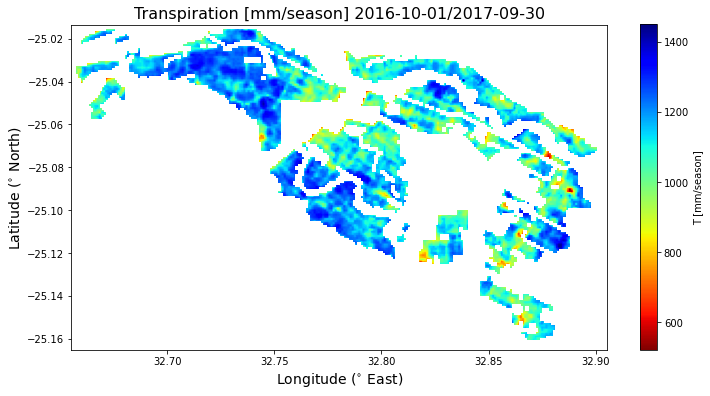

In [9]:
# collecting Geoinfo such as projection, the x and y axis
in_fh = input_fhsT[0]  

driver, NDV, xsize, ysize, GeoT, Projection = gis.GetGeoInfo(in_fh)
spatial_extent = (GeoT[0], GeoT[0] + GeoT[1] * xsize, GeoT[3] + GeoT[5] * ysize, GeoT[3])  # get spatial extent of raster

length = len(df_dates)  # length of season
#output_folderT

i = 0
while i < length:  
    # calculate the seasonal value and save in output_folderT
    seasonal = SumSeason(input_fhsT, df_dates.SOS[i].date(), df_dates.EOS[i].date(), df_availT)

    # save the seasonal array in raster format, name it with the raster name, sowing and harvesting date
    out_fh = os.path.join(output_folderT, 'T_' + str(df_dates.SOS[i].date()) + '_to_' + str(df_dates.EOS[i].date()) + '.tif')        
    gis.CreateGeoTiff(out_fh, seasonal, driver, NDV, xsize, ysize, GeoT, Projection)  # Save the array 'Sums' as raster
    print ('The mean & SD seasonal T [mm/season] in ', str(df_dates.SOS[i].date()) + '/' + str(df_dates.EOS[i].date()), ' is ', np.nanmean(seasonal).round(1), np.nanstd(seasonal).round(1))
   
    # calculate the mean, SD
    print ('the mean & SD for ',str(df_dates.SOS[i].date()) + '/' + str(df_dates.EOS[i].date()), '=', np.nanmean(seasonal).round(1),'&',np.nanstd(seasonal).round(1))

    # Plot the raster map
    plt.figure(figsize = (12,8))
    plt.imshow(seasonal, cmap='jet_r', vmin=np.nanmin(seasonal), vmax=np.nanmax(seasonal), extent=spatial_extent)
    plt.colorbar(shrink=0.75, label='T [mm/season]')
    plt.xlabel('Longitude ($^{\circ}$ East)', fontsize=14)  # add axes label
    plt.ylabel('Latitude ($^{\circ}$ North)', fontsize=14)
    plt.title('Transpiration [mm/season] ' + str(df_dates.SOS[i].date()) + '/' + str(df_dates.EOS[i].date()), fontsize=16)
    # plt.clim(0,1500)
    plt.show ()
    
    i += 1

## ii) Calculate seasonal evapotratranspiration

The mean & SD seasonal T [mm/season] in  2016-10-01/2017-09-30  is  1347.2 116.8
the mean & SD for  2016-10-01/2017-09-30 = 1347.2 & 116.8


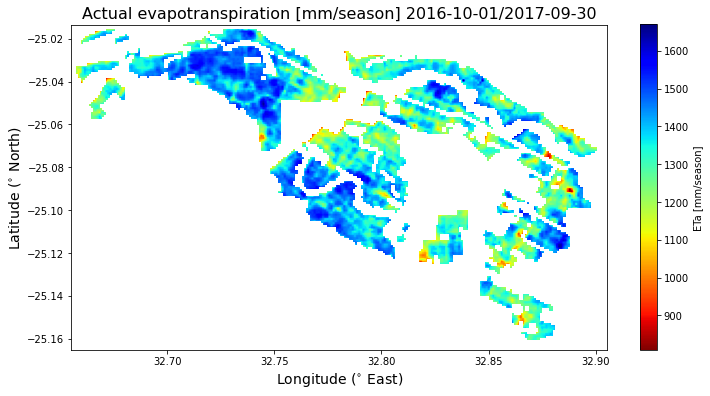

In [10]:
# collecting Geoinfo such as projection, the x and y axis
in_fh = input_fhsET[0]    

driver, NDV, xsize, ysize, GeoT, Projection = gis.GetGeoInfo(in_fh)
spatial_extent = (GeoT[0], GeoT[0] + GeoT[1] * xsize, GeoT[3] + GeoT[5] * ysize, GeoT[3])  # get spatial extent of raster

length = len(df_dates)  # length of seasonn
                
i = 0
while i < length:    
    # calculate the seasonal value and save in output_folder
    seasonal = SumSeason(input_fhsET, df_dates.SOS[i].date(), df_dates.EOS[i].date(), df_availET)

    # save the seasonal array in raster format, name it with the raster name, sowing and harvesting date
    out_fh = os.path.join(output_folderET, 'ETa_' + str(df_dates.SOS[i].date()) + '_to_' + str(df_dates.EOS[i].date()) + '.tif')        
    gis.CreateGeoTiff(out_fh, seasonal, driver, NDV, xsize, ysize, GeoT, Projection)  # Save the array 'Sums' as raster
    print ('The mean & SD seasonal T [mm/season] in ', str(df_dates.SOS[i].date()) + '/' + str(df_dates.EOS[i].date()), ' is ', np.nanmean(seasonal).round(1), np.nanstd(seasonal).round(1))
    
    # calculate the mean, SD
    print ('the mean & SD for ',str(df_dates.SOS[i].date()) + '/' + str(df_dates.EOS[i].date()), '=', np.nanmean(seasonal).round(1),'&',np.nanstd(seasonal).round(1))

    # Plot the raster map
    plt.figure(figsize = (12,8))
    plt.imshow(seasonal, cmap='jet_r', vmin=np.nanmin(seasonal), vmax=np.nanmax(seasonal), extent=spatial_extent)
    plt.colorbar(shrink=0.75, label='ETa [mm/season]')
    plt.xlabel('Longitude ($^{\circ}$ East)', fontsize=14)  # add axes label
    plt.ylabel('Latitude ($^{\circ}$ North)', fontsize=14)
    plt.title('Actual evapotranspiration [mm/season] ' + str(df_dates.SOS[i].date()) + '/' + str(df_dates.EOS[i].date()), fontsize=16)
    # plt.clim(0,1600)
    plt.show()

    i += 1

## iii) Calculate seasonal Reference Evapotranspiration(RET), and Potentail crop water requirement ETp(ETc) = Kc*RET

Themean & SD seasonal ET0 [mm] in  2016-10-01/2017-09-30  is  1731.5 28.0
The mean & SD seasonal ETc [mm] in  2016-10-01/2017-09-30  is  1750.0 26.7


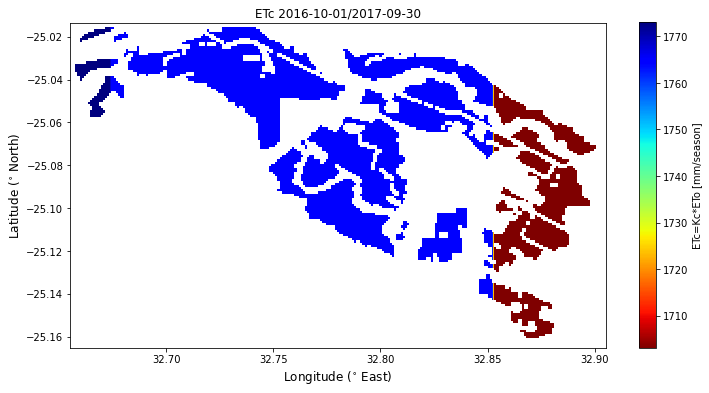

In [11]:
# collecting Geoinfo such as projection, the x and y axis
in_fh = input_fhsRET[0]
driver, NDV, xsize, ysize, GeoT, Projection = gis.GetGeoInfo(in_fh)
spatial_extent = (GeoT[0], GeoT[0] + GeoT[1] * xsize, GeoT[3] + GeoT[5] * ysize, GeoT[3])  # get spatial extent of raster

length = len(df_dates)  # length of season

i = 0
while i < length: 
    date_s  = df_dates.SOS[i].date()   # the starting date of the season (SOS)
    date_e =  df_dates.EOS[i].date()   # the end date of the season (EOS)
    SOS = date_s
    EOS = date_e

    # adjust kc curve for the active cropping period
    defaultCropPeriod = df_kc.Days[df_kc.Stages=='late-season_e']
    cropperiod        = EOS - SOS
    periodcorrection  = cropperiod.days/defaultCropPeriod
    df_kc['Days_corr'] = df_kc.apply(lambda row: (row['Days']*periodcorrection).round(0), axis=1)
    df_kc['Date']      = df_kc.apply(lambda row: SOS + datetime.timedelta(days=row['Days_corr']), axis=1)

    xcorr = df_kc['Days_corr']
    y = df_kc['kc']
    fkcnew      = interp1d(xcorr, y, kind='linear')
    
    # plot kc curves (default and adjusted) for field ID==1
    if i ==1:
        x     = df_kc['Days']
        fkcdefaulut = interp1d(x, y,    kind='linear')
        fkcnew      = interp1d(xcorr, y, kind='linear')

        plt.plot(x, y, 'ro', x, fkcdefaulut(x), 'r--', xcorr, fkcnew(xcorr), 'g--')
        plt.legend(['default kc', 'linear interpolation of default','updated kc'], loc='best')
        plt.show()

    seasonETo = 0  # initiaize for a season
    seasonETp = 0 
    while date_s < date_e:
        #start and end dates of the month
        #---- functions returning the first and last day of a month------
        def first_day_of_month(date):
            if date.month == 12:
               return date.replace(day=1)
            return date.replace(month=date.month, day=1)
          
        def last_day_of_month(date):
            if date.month == 12:
               return date.replace(day=31)
            return date.replace(month=date.month+1, day=1) - datetime.timedelta(days=1)

        startdate = max (first_day_of_month (date_s),SOS)
        enddate   = min (last_day_of_month(date_s),EOS)

        # average kc of the month
        kc_s = fkcnew((startdate - SOS).days)
        kc_f = fkcnew((enddate - SOS).days)
        kc_m = (kc_s+kc_f)/2

        # calculate the monthly ETo and ETp
        ET0m = SumSeason(input_fhsRET, startdate, enddate, df_availRET)
        ETp  = kc_m*ET0m    # calculate monthly ETP (ETc)

        # increament by a month
        if date_s.month == 12:
            date_s = date_s.replace(year=date_s.year+1,month=1,day=1)
        else:
            date_s = date_s.replace(month=date_s.month+1, day=1) 
            
        # add the monthly values for a season
        seasonETo+= ET0m
        seasonETp+= ETp      
    
    # save the seasonal array in raster format, name it with the raster name, sowing and harvesting date
    out_fh = os.path.join(output_folderRET, 'ET0_' + str(df_dates.SOS[i].date()) + '_to_' + str(df_dates.EOS[i].date()) + '.tif')        
    gis.CreateGeoTiff(out_fh, seasonETo, driver, NDV, xsize, ysize, GeoT, Projection)  # Save the array 'Sums' as raster
    print ('Themean & SD seasonal ET0 [mm] in ', str(df_dates.SOS[i].date()) + '/' + str(df_dates.EOS[i].date()), ' is ', np.nanmean(seasonETo).round(1), np.nanstd(seasonETo).round(1))

    out_fh = os.path.join(output_folderETp, 'ETc_' + str(df_dates.SOS[i].date()) + '_to_' + str(df_dates.EOS[i].date()) + '.tif')        
    gis.CreateGeoTiff(out_fh, seasonETp, driver, NDV, xsize, ysize, GeoT, Projection)  # Save the array 'Sums' as raster
    print ('The mean & SD seasonal ETc [mm] in ', str(df_dates.SOS[i].date()) + '/' + str(df_dates.EOS[i].date()), ' is ', np.nanmean(seasonETp).round(1),np.nanstd(seasonETp).round(1))


    # Plot the raster map
    plt.figure(figsize = (12,8))
    plt.imshow(seasonETp, cmap='jet_r', vmin=np.nanmin(seasonETp), vmax=np.nanmax(seasonETp),extent=spatial_extent)  
    plt.colorbar(shrink=0.75, label='ETc=Kc*ETo [mm/season]')
    plt.xlabel('Longitude ($^{\circ}$ East)', fontsize=12)  # add axes label
    plt.ylabel('Latitude ($^{\circ}$ North)', fontsize=12)
    plt.title('ETc ' + str(df_dates.SOS[i].date()) + '/' + str(df_dates.EOS[i].date()), fontsize=12)
    plt.clim()
    plt.show ()

    i += 1

## iv) Calculate monthly and seasonal precipitaiton (P)&effective precipitation (Peff) 
USDA Soil Conservation Service: Formula developed by USCS, where effective rainfall can be calculated according to:  
Monthly step:  
* Peff = Pmonth * (125 - 0.2 * Pmonth) / 125 for Pmonth <= 250 mm
* Peff = 125 + 0.1 * Pmonth for Pmonth > 250 mm

np.where(PCP<=250, PCP*(126-0.2*PCP)/125, np.where(PCP>250, 125 + 0.1*PCP, np.nan)

Themean & SD seasonal PCP [mm] in  2016-10-01/2017-09-30  is  865.4 63.5
The mean & SD seasonal Peff [mm] in  2016-10-01/2017-09-30  is  696.2 39.8


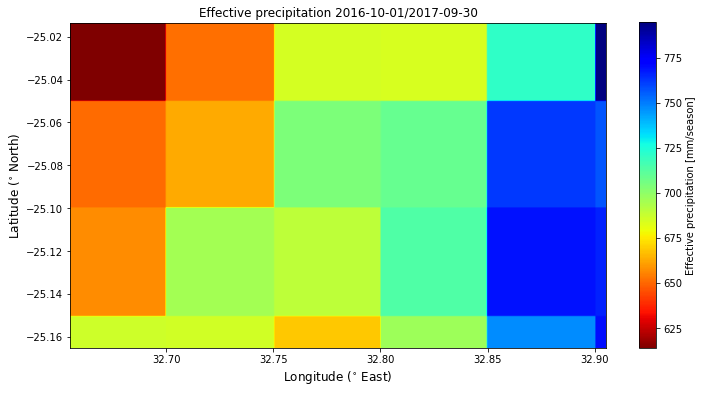

In [12]:
# collecting Geoinfo such as projection, the x and y axis
in_fh = input_fhsPCP[0]  
driver, NDV, xsize, ysize, GeoT, Projection = gis.GetGeoInfo(in_fh)
spatial_extent = (GeoT[0], GeoT[0] + GeoT[1] * xsize, GeoT[3] + GeoT[5] * ysize, GeoT[3])  # get spatial extent of raster

length = len(df_dates)  # length of season

i = 0
while i < length: 
    date_s  = df_dates.SOS[i].date()   # the starting date of the season (SOS)
    date_e =  df_dates.EOS[i].date()   # the end date of the season (EOS)
    SOS = date_s
    EOS = date_e

    seasonPCP  = 0  # initiaize for a season
    seasonPeff = 0 
    while date_s < date_e:
        #start and end dates of the month
        #---- functions returning the first and last day of a month------
        def first_day_of_month(date):
            if date.month == 12:
               return date.replace(day=1)
            return date.replace(month=date.month, day=1)
          
        def last_day_of_month(date):
            if date.month == 12:
               return date.replace(day=31)
            return date.replace(month=date.month+1, day=1) - datetime.timedelta(days=1)

        startdate = max (first_day_of_month (date_s),SOS)
        enddate   = min (last_day_of_month(date_s),EOS)

        # calculate the monthly PCP and Peff
        PCPm  = SumSeason(input_fhsPCP, startdate, enddate, df_availPCP)
        Peffm = np.where(PCPm<=250, PCPm*(125-0.2*PCPm)/125, np.where(PCPm>250, 125 + 0.1*PCPm, np.nan))   # calculate monthly effective precipitation (PCPeff)

        # increament by a month
        if date_s.month == 12:
            date_s = date_s.replace(year=date_s.year+1,month=1,day=1)
        else:
            date_s = date_s.replace(month=date_s.month+1, day=1) 
            
        # add the monthly values for a season
        seasonPCP  += PCPm
        seasonPeff += Peffm      
    
    # save the seasonal array in raster format, name it with the raster name, sowing and harvesting date
    out_fh = os.path.join(output_folderPCP, 'PCP_' + str(df_dates.SOS[i].date()) + '_to_' + str(df_dates.EOS[i].date()) + '.tif')        
    gis.CreateGeoTiff(out_fh, seasonPCP, driver, NDV, xsize, ysize, GeoT, Projection)  # Save the array 'Sums' as raster
    print ('Themean & SD seasonal PCP [mm] in ', str(df_dates.SOS[i].date()) + '/' + str(df_dates.EOS[i].date()), ' is ', np.nanmean(seasonPCP).round(1), np.nanstd(seasonPCP).round(1))

    out_fh = os.path.join(output_folderPCPeff , 'Peff_' + str(df_dates.SOS[i].date()) + '_to_' + str(df_dates.EOS[i].date()) + '.tif')        
    gis.CreateGeoTiff(out_fh, seasonPeff, driver, NDV, xsize, ysize, GeoT, Projection)  # Save the array 'Sums' as raster
    print ('The mean & SD seasonal Peff [mm] in ', str(df_dates.SOS[i].date()) + '/' + str(df_dates.EOS[i].date()), ' is ', np.nanmean(seasonPeff).round(1),np.nanstd(seasonPeff).round(1))


    # Plot the raster map
    plt.figure(figsize = (12,8))
    plt.imshow(seasonPeff, cmap='jet_r', vmin=np.nanmin(seasonPeff), vmax=np.nanmax(seasonPeff),extent=spatial_extent)  
    plt.colorbar(shrink=0.75, label='Effective precipitation [mm/season]')
    plt.xlabel('Longitude ($^{\circ}$ East)', fontsize=12)  # add axes label
    plt.ylabel('Latitude ($^{\circ}$ North)', fontsize=12)
    plt.title('Effective precipitation ' + str(df_dates.SOS[i].date()) + '/' + str(df_dates.EOS[i].date()), fontsize=12)
    plt.clim()
    plt.show ()

    i += 1

## v) Calculate seasonal geen and blue water consumption, Green ETa and Blue ETa
* Green ETa = min (Pe, ETa)
* Blue ETa  = max (0, ETa - Pe)
* where ETa is actual evapotranpiration and Pe is effective precipitaiton 

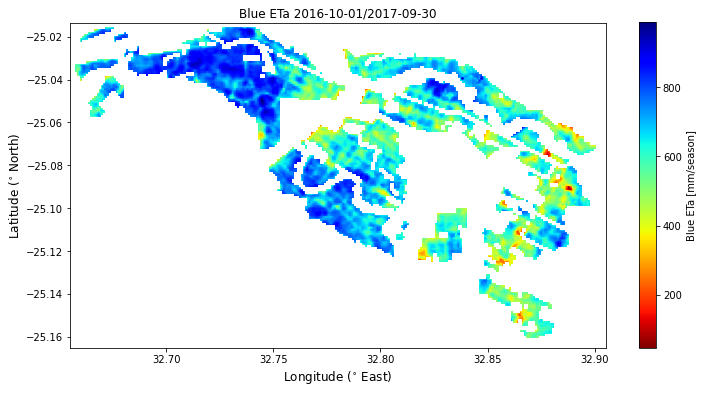

In [13]:
import pandas as pd

dir_proj = '/content/drive/My Drive/WAPORWP'
dir_data = "Data"


input_folderETa = os.path.join(dir_proj, dir_data, "2L2_AETI_season") 
input_fhsETa    = sorted(glob.glob(input_folderETa + '/*.tif'))      
input_folderPeff= os.path.join(dir_proj, dir_data, "2L1_PCPeff_season") 
input_fhsPeff   = sorted(glob.glob(input_folderPeff + '/*.tif'))            

# collecting Geoinfo such as projection, the x and y axis
in_fh = input_fhsETa[0]
driver, NDV, xsize, ysize, GeoT, Projection = gis.GetGeoInfo(in_fh)
spatial_extent = (GeoT[0], GeoT[0] + GeoT[1] * xsize, GeoT[3] + GeoT[5] * ysize, GeoT[3])  # get spatial extent of raster

#Initiate dataframe
df = pd.DataFrame (columns=['Season','GreenETa_mean','GreenETa_SD','BlueETa_mean','BlueETa_SD','ETa_mean','ETa_SD'])
i =0

for in_fhPeff, in_fhETa in zip(input_fhsPeff,input_fhsETa):
  Peff  = gis.OpenAsArray(in_fhPeff, nan_values=True)
  ETa   = gis.OpenAsArray(in_fhETa, nan_values=True)

  GreenETa = np.where(Peff<=ETa, Peff, ETa)   #min(Peff, ETa)
  BlueETa  = np.where (Peff>=ETa,0,ETa-Peff)  #max(0, ETa-Peff)

  season = str(df_dates.SOS[i].date())+ '/' +str(df_dates.EOS[i].date())

  # save the seasonal array in raster format, name it with the raster name, sowing and harvesting date
  out_fh = os.path.join(output_folderGreenBlueET, 'GreenETa_' + str(df_dates.SOS[i].date()) + '_to_' + str(df_dates.EOS[i].date()) + '.tif')        
  gis.CreateGeoTiff(out_fh, GreenETa, driver, NDV, xsize, ysize, GeoT, Projection)  # Save the array 'Sums' as raster

  out_fh = os.path.join(output_folderGreenBlueET, 'BlueETa_' + str(df_dates.SOS[i].date()) + '_to_' + str(df_dates.EOS[i].date()) + '.tif')        
  gis.CreateGeoTiff(out_fh, BlueETa, driver, NDV, xsize, ysize, GeoT, Projection)  # Save the array 'Sums' as raster

  # Plot the raster map
  plt.figure(figsize = (12,8))
  plt.imshow(BlueETa, cmap='jet_r', vmin=np.nanmin(BlueETa), vmax=np.nanmax(BlueETa),extent=spatial_extent)  
  plt.colorbar(shrink=0.75, label='Blue ETa [mm/season]')
  plt.xlabel('Longitude ($^{\circ}$ East)', fontsize=12)  # add axes label
  plt.ylabel('Latitude ($^{\circ}$ North)', fontsize=12)
  plt.title('Blue ETa ' + str(df_dates.SOS[i].date()) + '/' + str(df_dates.EOS[i].date()), fontsize=12)
  plt.clim()
  plt.show ()

  # save the data into dataframe - tabular form
  data  = [{'Season':season,'GreenETa_mean':np.nanmean(GreenETa),'GreenETa_SD':np.nanstd(GreenETa),
            'BlueETa_mean':np.nanmean(BlueETa),'BlueETa_SD':np.nanstd(BlueETa),'ETa_mean':np.nanmean(ETa),'ETa_SD':np.nanstd(ETa)}]
  df1   = pd.DataFrame(data) 

  #update the dataframe by concatenating to the new current 
  df=df.append(df1, ignore_index = True)

  i+=1

In [14]:

# export(save) the dataframe to excel
df.to_excel(os.path.join(output_folderGreenBlueET,   'Green&BlueETa.xlsx'))
df

,Season,GreenETa_mean,GreenETa_SD,BlueETa_mean,BlueETa_SD,ETa_mean,ETa_SD
0,2016-10-01/2017-09-30,703.452087,43.273201,643.759644,132.178574,1347.211548,116.787613


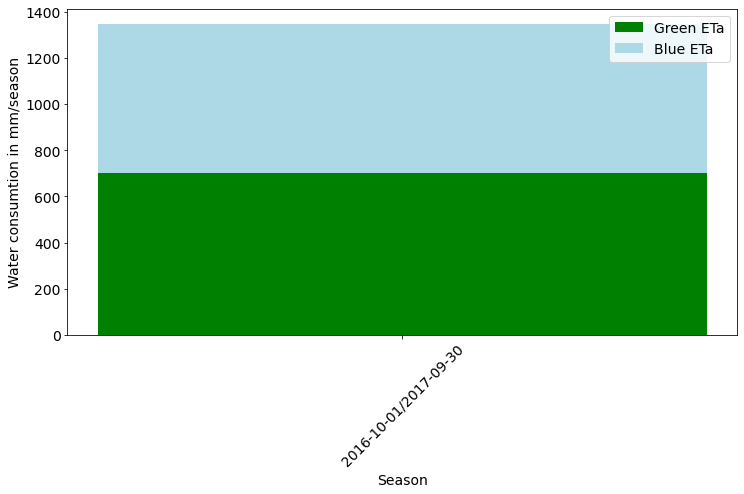

In [15]:
# Plot Green and blue water consumption trends
# data set
x = df.Season[:]
y1 = df.GreenETa_mean[:]
y2 = df.BlueETa_mean[:]

# plot stacked bar chart 
plt.subplots(figsize=(12, 6))
plt.bar(x, y1, color='g', label='Green ETa')
plt.bar(x, y2, bottom=y1, color='lightblue', label='Blue ETa')
plt.xlabel('Season', fontsize=14)
plt.ylabel('Water consumtion in mm/season', fontsize=14)
plt.xticks(fontsize= 14) 
plt.yticks(fontsize= 14)
plt.xticks(rotation=45)
plt.legend(fontsize=14)

plt.show()

## vi) Calculate seasonal Net Primary Production (NPP)

Themean & SD seasonal NPP [gC/m2/season] in  2016-10-01/2017-09-30  is  1045.6 98.6
the mean & SD for  2016-10-01/2017-09-30 = 1045.6 & 98.6


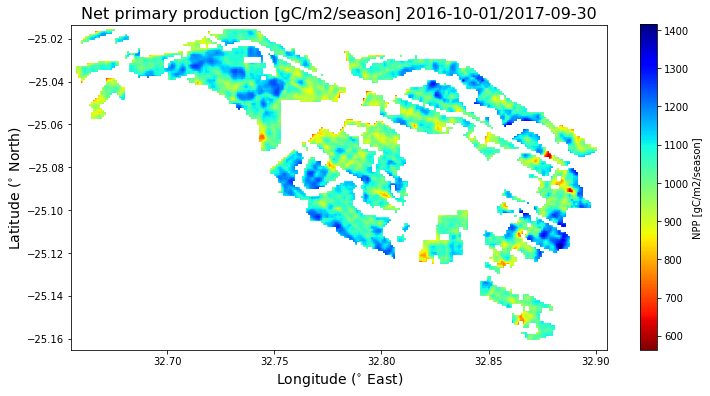

In [16]:
# collecting Geoinfo such as projection, the x and y axis
in_fh = input_fhsNPP[0]

driver, NDV, xsize, ysize, GeoT, Projection = gis.GetGeoInfo(in_fh)
spatial_extent = (GeoT[0], GeoT[0] + GeoT[1] * xsize, GeoT[3] + GeoT[5] * ysize, GeoT[3])  # get spatial extent of raster

length = len(df_dates)  # length of season

i = 0
while i < length:
    # calculate the seasonal value and save in output_folder
    seasonal = SumSeason(input_fhsNPP, df_dates.SOS[i].date(), df_dates.EOS[i].date(), df_availNPP)
    
    # save the seasonal array in raster format, name it with the raster name, sowing and harvesting date
    out_fh = os.path.join(output_folderNPP, 'NPP_' + str(df_dates.SOS[i].date()) + '_to_' + str(df_dates.EOS[i].date()) + '.tif')        
    gis.CreateGeoTiff(out_fh, seasonal, driver, NDV, xsize, ysize, GeoT, Projection)  # Save the array 'Sums' as raster
    print ('Themean & SD seasonal NPP [gC/m2/season] in ', str(df_dates.SOS[i].date()) + '/' + str(df_dates.EOS[i].date()), ' is ', np.nanmean(seasonal).round(1), np.nanstd(seasonal).round(1))

    # calculate the mean, SD
    print ('the mean & SD for ',str(df_dates.SOS[i].date()) + '/' + str(df_dates.EOS[i].date()), '=', np.nanmean(seasonal).round(1),'&',np.nanstd(seasonal).round(1))
    
    # Plot the raster map
    plt.figure(figsize = (12,8))
    plt.imshow(seasonal, cmap='jet_r', vmin=np.nanmin(seasonal), vmax=np.nanmax(seasonal), extent=spatial_extent)
    plt.colorbar(shrink=0.75, label='NPP [gC/m2/season]')
    plt.xlabel('Longitude ($^{\circ}$ East)', fontsize=14)  # add axes label
    plt.ylabel('Latitude ($^{\circ}$ North)', fontsize=14)
    plt.title('Net primary production [gC/m2/season] ' + str(df_dates.SOS[i].date()) + '/' + str(df_dates.EOS[i].date()), fontsize=16)
    plt.show ()
    
    i += 1 